# KNN
## -> removing stopwords, with stemming
## K = 19  
## Acc: 0.77125   
## F1: 0.7726708074534162

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict
from sklearn.metrics import classification_report,r2_score,recall_score,confusion_matrix

In [3]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IMDB_Dataset.csv')
df_sampled = train_df.sample(12000)
df_target = df_sampled['sentiment']
df_data = df_sampled.copy()
df_data.drop(columns='sentiment',inplace=True)

df_target.head()

968      positive
2902     negative
16068    negative
10665    negative
38517    positive
Name: sentiment, dtype: object

Preprocessing

In [4]:
df_data

,review
968,This is a great film. Touching and strong. The...
2902,So.. what can I tell you about this movie. If ...
16068,Kirsten Dunst is terribly overrated as an actr...
10665,"So, it has come to this. In the top-rated comm..."
38517,"Beautiful story of Wisconsin native, Dan Janse..."
...,...
28889,This is a truly awful film. What they have don...
18408,Fellow Giallo-fanatics: beware and/or proceed ...
10943,"Penn takes the time to develop his characters,..."
11673,"Film starts off great in 1872 with a violent, ..."


In [5]:
import re
#Removes Punctuations
def remove_punctuations(data):
    punct_tag=re.compile(r'[^\w\s]')
    data=punct_tag.sub(r'',data)
    return data

#Removes HTML syntaxes
def remove_html(data):
    html_tag=re.compile(r'<.*?>')
    data=html_tag.sub(r'',data)
    return data

#Removes URL data
def remove_url(data):
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data

#Removes Emojis
def remove_emoji(data):
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    data=emoji_clean.sub(r'',data)
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data

df_data['review']=df_data['review'].apply(lambda z: remove_punctuations(z)).apply(lambda z: remove_html(z))
df_data['review']=df_data['review'].apply(lambda z: remove_url(z)).apply(lambda z: remove_emoji(z))
# Remove all the special characters
df_data['review']=df_data['review'].apply(lambda z: re.sub(r'\W', ' ', z))
# remove all single characters
df_data['review']=df_data['review'].apply(lambda z: re.sub(r'\s+[a-zA-Z]\s+', ' ', z))
# Remove single characters from the start
df_data['review']=df_data['review'].apply(lambda z: re.sub(r'\^[a-zA-Z]\s+', ' ', z)) 
# Substituting multiple spaces with single space
df_data['review']=df_data['review'].apply(lambda z: re.sub(r'\s+', ' ', z, flags=re.I))
# Removing prefixed 'br'
df_data['review']=df_data['review'].apply(lambda z: re.sub(r'^br\s+', '', z))
# if you want to turn reviews into lists. use this. (algorithm dependent)
#df_data['review']=df_data['review'].apply(lambda z: z.split())
#encode target to numeric
df_target = df_target.apply(lambda x: 1 if x == "positive" else 0)

In [6]:
df_target

968      1
2902     0
16068    0
10665    0
38517    1
        ..
28889    0
18408    0
10943    0
11673    0
1233     1
Name: sentiment, Length: 12000, dtype: int64

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

#Apply CountVectorizer on text column

vectorizer = CountVectorizer(binary=True)

#If this vectorizer is used, a word which occurs multiple times is counted and not just displayed as 1 = word occurs 
#cVectorizer = CountVectorizer(binary=False)

matrix = vectorizer.fit_transform(df_data["review"])

print("Vectorizer created {} features.".format(len(vectorizer.get_feature_names())))

df_data_countVectorized = pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names())
display(df_data_countVectorized)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Vectorizer created 83391 features.


,00,00000001,00000110,006,007,0079,007s,0080,0083,009,...,æon,élan,émigré,êtrepeutêtre,örnek,über,überspy,übertrash,ünel,þór
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import re, string

#when running for the first time you need to activate this line for once.
nltk.download('stopwords')

#definition of stemming function
token_pattern = re.compile(r"(?u)\b\w\w+\b") # split on whitespace

def tokenize(text):
    my_stopwords = set(stopwords.words('english'))
    stemmer = PorterStemmer()
    stems = []
    
    tokens = token_pattern.findall(text)
    for item in tokens:
        if item not in my_stopwords:
            stems.append(stemmer.stem(item))
    return stems

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
stem_vectorizer = TfidfVectorizer(tokenizer=tokenize, min_df=0.0015)
matrix = stem_vectorizer.fit_transform(df_data["review"])
matrix

<12000x6217 sparse matrix of type '<class 'numpy.float64'>'
	with 1037124 stored elements in Compressed Sparse Row format>

In [10]:
df_data_stemmed = pd.DataFrame(matrix.toarray(), columns=stem_vectorizer.get_feature_names())
display(df_data_stemmed)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,010,10,100,1000,101,1010,10br,11,110,12,...,youngster,your,youth,youtub,youv,zani,zero,zombi,zone,zoom
0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.139276,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.074933,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0.0,0.085503,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.126621,0.0,0.0,0.0
11996,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
11997,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
11998,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


KNN

In [11]:
# Create train/test split
df_data_train, df_data_test, df_target_train, df_target_test = train_test_split(
    df_data_stemmed, df_target, test_size=0.2, random_state=42)

for n_neighbors in range(3,21):#[1,2,3,4,5]:#1,2,3,4,5
    knn_estimator = KNeighborsClassifier(n_neighbors)
    knn_estimator.fit(df_data_train, df_target_train)
    df_prediction = knn_estimator.predict(df_data_test)
    print("k= {} acc: {} F1: {}".format(n_neighbors, accuracy_score(df_target_test, df_prediction), f1_score(df_target_test, df_prediction)))




k= 3 acc: 0.7025 F1: 0.7052023121387283
k= 4 acc: 0.7129166666666666 F1: 0.6778868630201028
k= 5 acc: 0.7229166666666667 F1: 0.7273472734727345
k= 6 acc: 0.7279166666666667 F1: 0.7033166742389823
k= 7 acc: 0.73625 F1: 0.7421588594704683
k= 8 acc: 0.7441666666666666 F1: 0.7278368794326241
k= 9 acc: 0.7466666666666667 F1: 0.7506152584085316
k= 10 acc: 0.7495833333333334 F1: 0.7378979502834714
k= 11 acc: 0.75 F1: 0.7534921939194742
k= 12 acc: 0.7575 F1: 0.7449605609114812
k= 13 acc: 0.7583333333333333 F1: 0.7595356550580431
k= 14 acc: 0.7575 F1: 0.7456293706293706
k= 15 acc: 0.7620833333333333 F1: 0.7645360824742268
k= 16 acc: 0.7658333333333334 F1: 0.7579672695951766
k= 17 acc: 0.7658333333333334 F1: 0.7673841059602649
k= 18 acc: 0.7695833333333333 F1: 0.7615351444588185
k= 19 acc: 0.77125 F1: 0.7726708074534162
k= 20 acc: 0.7695833333333333 F1: 0.7617406290392073


k= 3 acc: 0.692 F1: 0.7118802619270347  
k= 4 acc: 0.6805 F1: 0.6591999999999999  
k= 5 acc: 0.7005 F1: 0.7191748710736052  
k= 6 acc: 0.7055 F1: 0.6943435391800725  
k= 7 acc: 0.714 F1: 0.7263157894736842  
k= 8 acc: 0.7105 F1: 0.7020072053525475  
k= 9 acc: 0.73 F1: 0.7403846153846154  
k= 10 acc: 0.7265 F1: 0.7193432529502308  
k= 11 acc: 0.739 F1: 0.7483124397299903  
k= 12 acc: 0.735 F1: 0.7304170905391659  
k= 13 acc: 0.7395 F1: 0.7489156626506023  
k= 14 acc: 0.7435 F1: 0.7378640776699029  
k= 15 acc: 0.7545 F1: 0.7615347255949491  
k= 16 acc: 0.7525 F1: 0.7468030690537084  
k= 17 acc: 0.7645 F1: 0.7701317715959004  
k= 18 acc: 0.76 F1: 0.7543500511770725  
k= 19 acc: 0.7635 F1: 0.7698296836982969  
k= 20 acc: 0.7605 F1: 0.7552376085845681  

# best performing K parameter is k= 19

k= 19 acc: 0.77125 F1: 0.7726708074534162
0.7726708074534162


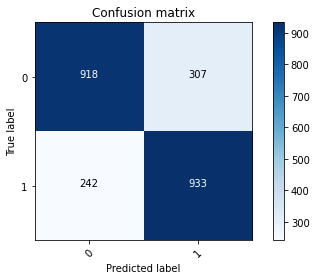

In [14]:
import itertools
import matplotlib.pyplot as plt
import numpy as np

knn_estimator = KNeighborsClassifier(19)
knn_estimator.fit(df_data_train, df_target_train)
df_prediction = knn_estimator.predict(df_data_test)
print("k= {} acc: {} F1: {}".format(19, accuracy_score(df_target_test, df_prediction), f1_score(df_target_test, df_prediction)))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
cnf_matrix = confusion_matrix(df_target_test, df_prediction)
print(f1_score(df_target_test, df_prediction))
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=[0,1])